In [1]:

import torch
from torchvision import datasets, transforms
import numpy as np
from torch.utils.data.sampler import SubsetRandomSampler
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter

/home/prfl/.conda/envs/opencv/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,),)])

fashion_mnist = datasets.FashionMNIST("~/pytorch/FashionMNIST", download=True, train=True, transform=transform)
fashion_mnist_t = datasets.FashionMNIST("~/pytorch/FashionMNIST_T", download=True, train=False, transform=transform)

In [3]:
indices = list(range(len(fashion_mnist_t)))
np.random.shuffle(indices)
split =int(np.floor(0.95*len(fashion_mnist_t)))
train_sample = SubsetRandomSampler(indices[:split])
valid_sample = SubsetRandomSampler(indices[split:])

train_load = torch.utils.data.DataLoader(fashion_mnist, sampler=train_sample, batch_size=32)
valid_load = torch.utils.data.DataLoader(fashion_mnist, sampler=valid_sample, batch_size=32)
test_load = torch.utils.data.DataLoader(fashion_mnist_t, batch_size=32, shuffle=True)

/tmp/ipykernel_197351/1259538605.py:13: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


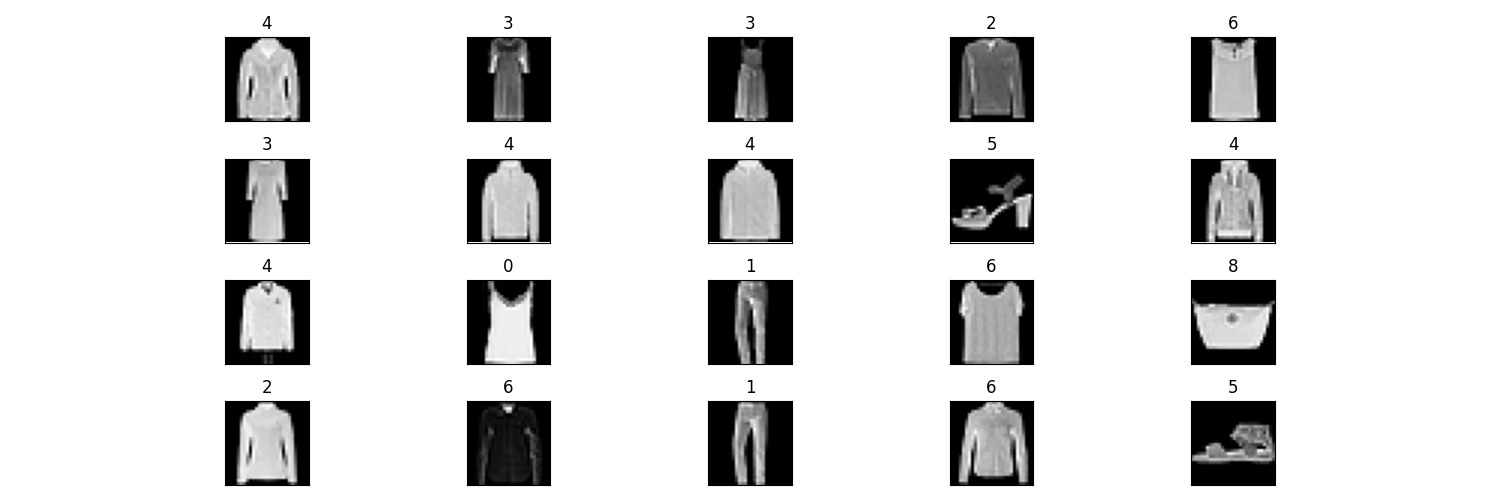

In [13]:
import matplotlib.pyplot as plt
%matplotlib widget

dataiter = iter(train_load)
print(dataiter)
images, labels = next(dataiter)

fig = plt.figure(figsize=(15, 5))
for idx in np.arange(20):
    ax = fig.add_subplot(4, int(20/4), idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap="gray")
    ax.set_title(labels[idx].item())
    fig.tight_layout()

In [5]:
import torch.nn as nn
import torch.optim as optim
writer = SummaryWriter()
criterion = nn.NLLLoss()
train_losses, test_losses = [], []
class CIFAR10Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.drop1 = nn.Dropout(0.3)
 
        self.conv2 = nn.Conv2d(32, 32, kernel_size=(3,3), stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=(2, 2))
 
        self.flat = nn.Flatten()
 
        self.fc3 = nn.Linear(6272, 512)
        self.act3 = nn.ReLU()
        self.drop3 = nn.Dropout(0.5)
 
        self.fc4 = nn.Linear(512, 10)
 
    def forward(self, x):
        # input 3x32x32, output 32x32x32
        x = self.act1(self.conv1(x))
        x = self.drop1(x)
        # input 32x32x32, output 32x32x32
        x = self.act2(self.conv2(x))
        # input 32x32x32, output 32x16x16
        x = self.pool2(x)
        # input 32x16x16, output 8192
        x = self.flat(x)
        # input 8192, output 512
        x = self.act3(self.fc3(x))
        x = self.drop3(x)
        # input 512, output 10
        x = self.fc4(x)
        return x
 
model = CIFAR10Model()
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
 
n_epochs = 400
for epoch in range(n_epochs):
    running_loss = 0

    for inputs, labels in tqdm(train_load):
        # forward, backward, and then weight update
        y_pred = model(inputs)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    test_loss = 0
    accuracy = 0
    
    # Turn off gradients for validation, saves memory and computation
    with torch.no_grad():
      # Set the model to evaluation mode
      model.eval()
      
      # Validation pass
      for images, labels in tqdm(test_load):
        # images = images.view(images.shape[0], -1)
        log_ps = model(images)
        test_loss += criterion(log_ps, labels)
        
        ps = torch.exp(log_ps)
        top_p, top_class = ps.topk(1, dim = 1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor))
    
    model.train()
    train_losses.append(running_loss/len(train_load))
    test_losses.append(test_loss/len(test_load))
    
    writer.add_scalar('Loss/train', running_loss/len(train_load), epoch)
    writer.add_scalar('Loss/test', test_loss/len(test_load), epoch)
    writer.add_scalar('Accuracy/test', accuracy/len(test_load), epoch)
    
    print("Epoch: {}/{}..".format(epoch+1, n_epochs),
          "Training loss: {:.3f}..".format(running_loss/len(train_load)),
          "Test loss: {:.3f}..".format(test_loss/len(test_load)),
          "Test Accuracy: {:.3f}".format(accuracy/len(test_load)))
 
torch.save(model.state_dict(), "cifar10model.pth")

  4%|▍         | 12/297 [00:08<03:30,  1.36it/s]


KeyboardInterrupt: 

In [ ]:

# # Define the network architecture
# from torch import nn, optim
# import torch.nn.functional as F
# writer = SummaryWriter()
# model = nn.Sequential(nn.Linear(784, 256),
#                       nn.ReLU(),
#                       nn.Dropout(0.3),
#                       nn.Linear(256, 128),
#                       nn.ReLU(),
#                       nn.Dropout(0.5),
#                       nn.Linear(128, 128),
#                       nn.ReLU(),
#                       nn.Dropout(0.5),
#                       nn.Linear(128, 64),
#                       nn.ReLU(),
#                       nn.Dropout(0.4),
#                       nn.Linear(64, 64),
#                       nn.ReLU(),
#                       nn.Dropout(0.4),
#                       nn.Linear(64, 10),
#                       nn.LogSoftmax(dim = 1)
#                      )


# # Define the loss
# criterion = nn.NLLLoss()

# # Define the optimizer
# optimizer = optim.Adam(model.parameters(), lr = 0.002)

# # Define the epochs
# epochs = 300

# train_losses, test_losses = [], []

# for e in range(epochs):
#   running_loss = 0
#   for images, labels in tqdm(train_load):
#     # Flatten Fashion-MNIST images into a 784 long vector
#     images = images.view(images.shape[0], -1)
    
#     # Training pass
#     optimizer.zero_grad()
    
#     output = model.forward(images)
#     loss = criterion(output, labels)
#     loss.backward()
#     optimizer.step()
    
#     running_loss += loss.item()
#   else:
#     test_loss = 0
#     accuracy = 0
    
#     # Turn off gradients for validation, saves memory and computation
#     with torch.no_grad():
#       # Set the model to evaluation mode
#       model.eval()
      
#       # Validation pass
#       for images, labels in tqdm(test_load):
#         images = images.view(images.shape[0], -1)
#         log_ps = model(images)
#         test_loss += criterion(log_ps, labels)
        
#         ps = torch.exp(log_ps)
#         top_p, top_class = ps.topk(1, dim = 1)
#         equals = top_class == labels.view(*top_class.shape)
#         accuracy += torch.mean(equals.type(torch.FloatTensor))
    
#     model.train()
#     train_losses.append(running_loss/len(train_load))
#     test_losses.append(test_loss/len(test_load))
    
#     writer.add_scalar('Loss/train', running_loss/len(train_load), e)
#     writer.add_scalar('Loss/test', test_loss/len(test_load), e)
#     writer.add_scalar('Accuracy/test', accuracy/len(test_load), e)
    
#     print("Epoch: {}/{}..".format(e+1, epochs),
#           "Training loss: {:.3f}..".format(running_loss/len(train_load)),
#           "Test loss: {:.3f}..".format(test_loss/len(test_load)),
#           "Test Accuracy: {:.3f}".format(accuracy/len(test_load)))

100%|██████████| 157/157 [00:01<00:00, 82.43it/s]


Epoch: 1/300.. Training loss: 1.571.. Test loss: 0.832.. Test Accuracy: 0.646


100%|██████████| 157/157 [00:01<00:00, 96.51it/s] 


Epoch: 2/300.. Training loss: 0.954.. Test loss: 0.771.. Test Accuracy: 0.642


100%|██████████| 157/157 [00:01<00:00, 100.25it/s]


Epoch: 3/300.. Training loss: 0.861.. Test loss: 0.721.. Test Accuracy: 0.675


100%|██████████| 157/157 [00:02<00:00, 77.26it/s]


Epoch: 4/300.. Training loss: 0.809.. Test loss: 0.695.. Test Accuracy: 0.714


100%|██████████| 157/157 [00:02<00:00, 63.44it/s]


Epoch: 5/300.. Training loss: 0.782.. Test loss: 0.673.. Test Accuracy: 0.749


100%|██████████| 157/157 [00:01<00:00, 85.05it/s]


Epoch: 6/300.. Training loss: 0.756.. Test loss: 0.671.. Test Accuracy: 0.726


100%|██████████| 157/157 [00:01<00:00, 91.82it/s]


Epoch: 7/300.. Training loss: 0.720.. Test loss: 0.658.. Test Accuracy: 0.768


100%|██████████| 157/157 [00:01<00:00, 83.57it/s]


Epoch: 8/300.. Training loss: 0.686.. Test loss: 0.608.. Test Accuracy: 0.765


100%|██████████| 157/157 [00:02<00:00, 73.41it/s]


Epoch: 9/300.. Training loss: 0.676.. Test loss: 0.594.. Test Accuracy: 0.779


100%|██████████| 157/157 [00:02<00:00, 67.33it/s]


Epoch: 10/300.. Training loss: 0.640.. Test loss: 0.595.. Test Accuracy: 0.782


100%|██████████| 157/157 [00:01<00:00, 94.19it/s]


Epoch: 11/300.. Training loss: 0.644.. Test loss: 0.577.. Test Accuracy: 0.788


100%|██████████| 157/157 [00:01<00:00, 94.56it/s]


Epoch: 12/300.. Training loss: 0.609.. Test loss: 0.582.. Test Accuracy: 0.791


100%|██████████| 157/157 [00:01<00:00, 97.89it/s]


Epoch: 13/300.. Training loss: 0.595.. Test loss: 0.570.. Test Accuracy: 0.795


100%|██████████| 157/157 [00:01<00:00, 89.73it/s]


Epoch: 14/300.. Training loss: 0.595.. Test loss: 0.568.. Test Accuracy: 0.796


100%|██████████| 157/157 [00:02<00:00, 73.01it/s]


Epoch: 15/300.. Training loss: 0.586.. Test loss: 0.555.. Test Accuracy: 0.797


100%|██████████| 157/157 [00:02<00:00, 77.50it/s]


Epoch: 16/300.. Training loss: 0.591.. Test loss: 0.573.. Test Accuracy: 0.801


100%|██████████| 157/157 [00:02<00:00, 75.96it/s]


Epoch: 17/300.. Training loss: 0.596.. Test loss: 0.573.. Test Accuracy: 0.788


100%|██████████| 157/157 [00:01<00:00, 83.66it/s]


Epoch: 18/300.. Training loss: 0.573.. Test loss: 0.554.. Test Accuracy: 0.801


100%|██████████| 157/157 [00:01<00:00, 96.77it/s]


Epoch: 19/300.. Training loss: 0.545.. Test loss: 0.543.. Test Accuracy: 0.803


100%|██████████| 157/157 [00:01<00:00, 95.39it/s]


Epoch: 20/300.. Training loss: 0.545.. Test loss: 0.579.. Test Accuracy: 0.797


100%|██████████| 157/157 [00:01<00:00, 83.75it/s]


Epoch: 21/300.. Training loss: 0.549.. Test loss: 0.533.. Test Accuracy: 0.819


100%|██████████| 157/157 [00:01<00:00, 84.11it/s]


Epoch: 22/300.. Training loss: 0.519.. Test loss: 0.544.. Test Accuracy: 0.808


100%|██████████| 157/157 [00:01<00:00, 93.77it/s] 


Epoch: 23/300.. Training loss: 0.523.. Test loss: 0.549.. Test Accuracy: 0.816


100%|██████████| 157/157 [00:02<00:00, 76.32it/s]


Epoch: 24/300.. Training loss: 0.517.. Test loss: 0.523.. Test Accuracy: 0.817


100%|██████████| 157/157 [00:01<00:00, 81.10it/s]


Epoch: 25/300.. Training loss: 0.517.. Test loss: 0.573.. Test Accuracy: 0.818


100%|██████████| 157/157 [00:01<00:00, 96.17it/s]


Epoch: 26/300.. Training loss: 0.524.. Test loss: 0.570.. Test Accuracy: 0.808


100%|██████████| 157/157 [00:01<00:00, 81.95it/s]


Epoch: 27/300.. Training loss: 0.514.. Test loss: 0.543.. Test Accuracy: 0.817


100%|██████████| 157/157 [00:02<00:00, 75.03it/s]


Epoch: 28/300.. Training loss: 0.509.. Test loss: 0.575.. Test Accuracy: 0.814


100%|██████████| 157/157 [00:02<00:00, 69.66it/s]


Epoch: 29/300.. Training loss: 0.520.. Test loss: 0.561.. Test Accuracy: 0.820


100%|██████████| 157/157 [00:01<00:00, 87.34it/s]


Epoch: 30/300.. Training loss: 0.514.. Test loss: 0.540.. Test Accuracy: 0.813


100%|██████████| 157/157 [00:01<00:00, 86.23it/s]


Epoch: 31/300.. Training loss: 0.527.. Test loss: 0.536.. Test Accuracy: 0.824


100%|██████████| 157/157 [00:01<00:00, 100.71it/s]


Epoch: 32/300.. Training loss: 0.494.. Test loss: 0.550.. Test Accuracy: 0.821


100%|██████████| 157/157 [00:02<00:00, 58.32it/s]


Epoch: 33/300.. Training loss: 0.486.. Test loss: 0.552.. Test Accuracy: 0.816


100%|██████████| 157/157 [00:01<00:00, 97.32it/s]


Epoch: 34/300.. Training loss: 0.478.. Test loss: 0.560.. Test Accuracy: 0.826


100%|██████████| 157/157 [00:01<00:00, 79.93it/s]


Epoch: 35/300.. Training loss: 0.483.. Test loss: 0.533.. Test Accuracy: 0.823


100%|██████████| 157/157 [00:02<00:00, 59.20it/s]


Epoch: 36/300.. Training loss: 0.482.. Test loss: 0.557.. Test Accuracy: 0.815


100%|██████████| 157/157 [00:02<00:00, 78.47it/s]


Epoch: 37/300.. Training loss: 0.486.. Test loss: 0.554.. Test Accuracy: 0.831


100%|██████████| 157/157 [00:02<00:00, 75.71it/s]


Epoch: 38/300.. Training loss: 0.484.. Test loss: 0.546.. Test Accuracy: 0.828


100%|██████████| 157/157 [00:01<00:00, 92.37it/s]


Epoch: 39/300.. Training loss: 0.494.. Test loss: 0.549.. Test Accuracy: 0.821


100%|██████████| 157/157 [00:01<00:00, 87.42it/s]


Epoch: 40/300.. Training loss: 0.466.. Test loss: 0.541.. Test Accuracy: 0.830


100%|██████████| 157/157 [00:02<00:00, 76.45it/s]


Epoch: 41/300.. Training loss: 0.459.. Test loss: 0.548.. Test Accuracy: 0.823


100%|██████████| 157/157 [00:01<00:00, 97.78it/s] 


Epoch: 42/300.. Training loss: 0.473.. Test loss: 0.558.. Test Accuracy: 0.833


100%|██████████| 157/157 [00:01<00:00, 86.36it/s]


Epoch: 43/300.. Training loss: 0.480.. Test loss: 0.531.. Test Accuracy: 0.829


100%|██████████| 157/157 [00:02<00:00, 75.05it/s]


Epoch: 44/300.. Training loss: 0.456.. Test loss: 0.539.. Test Accuracy: 0.830


100%|██████████| 157/157 [00:01<00:00, 99.14it/s] 


Epoch: 45/300.. Training loss: 0.484.. Test loss: 0.557.. Test Accuracy: 0.827


100%|██████████| 157/157 [00:01<00:00, 93.42it/s]


Epoch: 46/300.. Training loss: 0.486.. Test loss: 0.563.. Test Accuracy: 0.826


100%|██████████| 157/157 [00:01<00:00, 82.94it/s] 


Epoch: 47/300.. Training loss: 0.465.. Test loss: 0.612.. Test Accuracy: 0.823


100%|██████████| 157/157 [00:01<00:00, 89.67it/s]


Epoch: 48/300.. Training loss: 0.461.. Test loss: 0.546.. Test Accuracy: 0.831


100%|██████████| 157/157 [00:02<00:00, 72.17it/s]


Epoch: 49/300.. Training loss: 0.454.. Test loss: 0.600.. Test Accuracy: 0.834


100%|██████████| 157/157 [00:01<00:00, 85.55it/s]


Epoch: 50/300.. Training loss: 0.512.. Test loss: 0.548.. Test Accuracy: 0.831


100%|██████████| 157/157 [00:01<00:00, 97.70it/s] 


Epoch: 51/300.. Training loss: 0.448.. Test loss: 0.569.. Test Accuracy: 0.828


100%|██████████| 157/157 [00:02<00:00, 64.91it/s]


Epoch: 52/300.. Training loss: 0.441.. Test loss: 0.538.. Test Accuracy: 0.832


100%|██████████| 157/157 [00:02<00:00, 57.98it/s]


Epoch: 53/300.. Training loss: 0.440.. Test loss: 0.553.. Test Accuracy: 0.833


100%|██████████| 157/157 [00:02<00:00, 68.76it/s]


Epoch: 54/300.. Training loss: 0.471.. Test loss: 0.529.. Test Accuracy: 0.823


100%|██████████| 157/157 [00:02<00:00, 64.13it/s]


Epoch: 55/300.. Training loss: 0.459.. Test loss: 0.547.. Test Accuracy: 0.829


100%|██████████| 157/157 [00:01<00:00, 99.86it/s] 


Epoch: 56/300.. Training loss: 0.443.. Test loss: 0.526.. Test Accuracy: 0.833


100%|██████████| 157/157 [00:02<00:00, 65.56it/s]


Epoch: 57/300.. Training loss: 0.439.. Test loss: 0.567.. Test Accuracy: 0.827


100%|██████████| 157/157 [00:02<00:00, 64.98it/s]


Epoch: 58/300.. Training loss: 0.454.. Test loss: 0.535.. Test Accuracy: 0.834


100%|██████████| 157/157 [00:01<00:00, 102.30it/s]


Epoch: 59/300.. Training loss: 0.434.. Test loss: 0.554.. Test Accuracy: 0.833


100%|██████████| 157/157 [00:01<00:00, 95.69it/s]


Epoch: 60/300.. Training loss: 0.447.. Test loss: 0.586.. Test Accuracy: 0.818


100%|██████████| 157/157 [00:01<00:00, 86.96it/s]


Epoch: 61/300.. Training loss: 0.458.. Test loss: 0.591.. Test Accuracy: 0.825


100%|██████████| 157/157 [00:02<00:00, 69.65it/s]


Epoch: 62/300.. Training loss: 0.449.. Test loss: 0.531.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:01<00:00, 98.62it/s] 


Epoch: 63/300.. Training loss: 0.444.. Test loss: 0.561.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:02<00:00, 76.12it/s]


Epoch: 64/300.. Training loss: 0.416.. Test loss: 0.561.. Test Accuracy: 0.835


100%|██████████| 157/157 [00:02<00:00, 73.72it/s]


Epoch: 65/300.. Training loss: 0.435.. Test loss: 0.575.. Test Accuracy: 0.834


100%|██████████| 157/157 [00:01<00:00, 80.33it/s]


Epoch: 66/300.. Training loss: 0.445.. Test loss: 0.546.. Test Accuracy: 0.833


100%|██████████| 157/157 [00:02<00:00, 71.84it/s]


Epoch: 67/300.. Training loss: 0.453.. Test loss: 0.570.. Test Accuracy: 0.832


100%|██████████| 157/157 [00:01<00:00, 86.36it/s]


Epoch: 68/300.. Training loss: 0.424.. Test loss: 0.574.. Test Accuracy: 0.827


100%|██████████| 157/157 [00:01<00:00, 96.62it/s] 


Epoch: 69/300.. Training loss: 0.463.. Test loss: 0.593.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:01<00:00, 84.69it/s]


Epoch: 70/300.. Training loss: 0.460.. Test loss: 0.559.. Test Accuracy: 0.824


100%|██████████| 157/157 [00:01<00:00, 99.04it/s]


Epoch: 71/300.. Training loss: 0.433.. Test loss: 0.568.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:01<00:00, 79.89it/s]


Epoch: 72/300.. Training loss: 0.411.. Test loss: 0.572.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:02<00:00, 70.72it/s]


Epoch: 73/300.. Training loss: 0.422.. Test loss: 0.560.. Test Accuracy: 0.835


100%|██████████| 157/157 [00:02<00:00, 69.03it/s]


Epoch: 74/300.. Training loss: 0.430.. Test loss: 0.541.. Test Accuracy: 0.839


100%|██████████| 157/157 [00:01<00:00, 91.29it/s] 


Epoch: 75/300.. Training loss: 0.435.. Test loss: 0.564.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:02<00:00, 76.24it/s]


Epoch: 76/300.. Training loss: 0.424.. Test loss: 0.553.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:02<00:00, 76.38it/s]


Epoch: 77/300.. Training loss: 0.430.. Test loss: 0.565.. Test Accuracy: 0.833


100%|██████████| 157/157 [00:02<00:00, 73.18it/s]


Epoch: 78/300.. Training loss: 0.419.. Test loss: 0.555.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:01<00:00, 93.17it/s]


Epoch: 79/300.. Training loss: 0.411.. Test loss: 0.548.. Test Accuracy: 0.844


100%|██████████| 157/157 [00:01<00:00, 101.56it/s]


Epoch: 80/300.. Training loss: 0.419.. Test loss: 0.560.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 95.05it/s] 


Epoch: 81/300.. Training loss: 0.425.. Test loss: 0.566.. Test Accuracy: 0.833


100%|██████████| 157/157 [00:01<00:00, 98.37it/s]


Epoch: 82/300.. Training loss: 0.453.. Test loss: 0.567.. Test Accuracy: 0.823


100%|██████████| 157/157 [00:01<00:00, 101.53it/s]


Epoch: 83/300.. Training loss: 0.408.. Test loss: 0.560.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:01<00:00, 102.06it/s]


Epoch: 84/300.. Training loss: 0.427.. Test loss: 0.543.. Test Accuracy: 0.842


100%|██████████| 157/157 [00:01<00:00, 98.89it/s]


Epoch: 85/300.. Training loss: 0.413.. Test loss: 0.609.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:01<00:00, 103.43it/s]


Epoch: 86/300.. Training loss: 0.417.. Test loss: 0.577.. Test Accuracy: 0.834


100%|██████████| 157/157 [00:01<00:00, 84.59it/s]


Epoch: 87/300.. Training loss: 0.428.. Test loss: 0.580.. Test Accuracy: 0.841


100%|██████████| 157/157 [00:01<00:00, 95.64it/s]


Epoch: 88/300.. Training loss: 0.405.. Test loss: 0.609.. Test Accuracy: 0.831


100%|██████████| 157/157 [00:01<00:00, 101.87it/s]


Epoch: 89/300.. Training loss: 0.424.. Test loss: 0.589.. Test Accuracy: 0.842


100%|██████████| 157/157 [00:01<00:00, 89.74it/s]


Epoch: 90/300.. Training loss: 0.431.. Test loss: 0.635.. Test Accuracy: 0.822


100%|██████████| 157/157 [00:01<00:00, 101.72it/s]


Epoch: 91/300.. Training loss: 0.440.. Test loss: 0.661.. Test Accuracy: 0.824


100%|██████████| 157/157 [00:01<00:00, 91.89it/s] 


Epoch: 92/300.. Training loss: 0.445.. Test loss: 0.533.. Test Accuracy: 0.839


100%|██████████| 157/157 [00:01<00:00, 97.12it/s] 


Epoch: 93/300.. Training loss: 0.398.. Test loss: 0.570.. Test Accuracy: 0.844


100%|██████████| 157/157 [00:01<00:00, 100.44it/s]


Epoch: 94/300.. Training loss: 0.431.. Test loss: 0.562.. Test Accuracy: 0.839


100%|██████████| 157/157 [00:02<00:00, 78.05it/s]


Epoch: 95/300.. Training loss: 0.417.. Test loss: 0.567.. Test Accuracy: 0.844


100%|██████████| 157/157 [00:01<00:00, 78.73it/s]


Epoch: 96/300.. Training loss: 0.411.. Test loss: 0.550.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:02<00:00, 77.36it/s]


Epoch: 97/300.. Training loss: 0.404.. Test loss: 0.608.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:01<00:00, 78.69it/s]


Epoch: 98/300.. Training loss: 0.401.. Test loss: 0.578.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:01<00:00, 79.06it/s]


Epoch: 99/300.. Training loss: 0.464.. Test loss: 0.555.. Test Accuracy: 0.835


100%|██████████| 157/157 [00:02<00:00, 77.44it/s]


Epoch: 100/300.. Training loss: 0.408.. Test loss: 0.572.. Test Accuracy: 0.841


100%|██████████| 157/157 [00:01<00:00, 98.09it/s]


Epoch: 101/300.. Training loss: 0.393.. Test loss: 0.629.. Test Accuracy: 0.826


100%|██████████| 157/157 [00:01<00:00, 91.13it/s]


Epoch: 102/300.. Training loss: 0.449.. Test loss: 0.542.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:01<00:00, 99.33it/s] 


Epoch: 103/300.. Training loss: 0.427.. Test loss: 0.568.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:01<00:00, 92.99it/s]


Epoch: 104/300.. Training loss: 0.427.. Test loss: 0.571.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:01<00:00, 98.43it/s] 


Epoch: 105/300.. Training loss: 0.424.. Test loss: 0.534.. Test Accuracy: 0.841


100%|██████████| 157/157 [00:01<00:00, 102.41it/s]


Epoch: 106/300.. Training loss: 0.399.. Test loss: 0.599.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:01<00:00, 102.70it/s]


Epoch: 107/300.. Training loss: 0.459.. Test loss: 0.556.. Test Accuracy: 0.833


100%|██████████| 157/157 [00:01<00:00, 103.60it/s]


Epoch: 108/300.. Training loss: 0.421.. Test loss: 0.565.. Test Accuracy: 0.842


100%|██████████| 157/157 [00:01<00:00, 100.98it/s]


Epoch: 109/300.. Training loss: 0.418.. Test loss: 0.556.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:01<00:00, 93.99it/s] 


Epoch: 110/300.. Training loss: 0.395.. Test loss: 0.604.. Test Accuracy: 0.841


100%|██████████| 157/157 [00:01<00:00, 105.11it/s]


Epoch: 111/300.. Training loss: 0.424.. Test loss: 0.558.. Test Accuracy: 0.839


100%|██████████| 157/157 [00:01<00:00, 81.35it/s]


Epoch: 112/300.. Training loss: 0.474.. Test loss: 0.550.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:01<00:00, 99.90it/s]


Epoch: 113/300.. Training loss: 0.424.. Test loss: 0.574.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:01<00:00, 92.56it/s]


Epoch: 114/300.. Training loss: 0.435.. Test loss: 0.604.. Test Accuracy: 0.825


100%|██████████| 157/157 [00:01<00:00, 94.63it/s]


Epoch: 115/300.. Training loss: 0.425.. Test loss: 0.620.. Test Accuracy: 0.826


100%|██████████| 157/157 [00:01<00:00, 106.63it/s]


Epoch: 116/300.. Training loss: 0.418.. Test loss: 0.555.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 97.07it/s]


Epoch: 117/300.. Training loss: 0.394.. Test loss: 0.569.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:01<00:00, 92.90it/s]


Epoch: 118/300.. Training loss: 0.391.. Test loss: 0.573.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:01<00:00, 93.64it/s]


Epoch: 119/300.. Training loss: 0.406.. Test loss: 0.569.. Test Accuracy: 0.832


100%|██████████| 157/157 [00:01<00:00, 85.43it/s]


Epoch: 120/300.. Training loss: 0.413.. Test loss: 0.575.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:01<00:00, 90.97it/s]


Epoch: 121/300.. Training loss: 0.396.. Test loss: 0.631.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:01<00:00, 100.76it/s]


Epoch: 122/300.. Training loss: 0.436.. Test loss: 0.562.. Test Accuracy: 0.822


100%|██████████| 157/157 [00:01<00:00, 92.99it/s] 


Epoch: 123/300.. Training loss: 0.396.. Test loss: 0.573.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:01<00:00, 83.13it/s]


Epoch: 124/300.. Training loss: 0.391.. Test loss: 0.588.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 100.18it/s]


Epoch: 125/300.. Training loss: 0.402.. Test loss: 0.594.. Test Accuracy: 0.830


100%|██████████| 157/157 [00:01<00:00, 87.91it/s]


Epoch: 126/300.. Training loss: 0.396.. Test loss: 0.587.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:01<00:00, 97.82it/s] 


Epoch: 127/300.. Training loss: 0.396.. Test loss: 0.660.. Test Accuracy: 0.830


100%|██████████| 157/157 [00:01<00:00, 97.32it/s] 


Epoch: 128/300.. Training loss: 0.422.. Test loss: 0.596.. Test Accuracy: 0.835


100%|██████████| 157/157 [00:01<00:00, 99.53it/s] 


Epoch: 129/300.. Training loss: 0.411.. Test loss: 0.583.. Test Accuracy: 0.842


100%|██████████| 157/157 [00:01<00:00, 92.13it/s]


Epoch: 130/300.. Training loss: 0.386.. Test loss: 0.610.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:01<00:00, 95.44it/s] 


Epoch: 131/300.. Training loss: 0.392.. Test loss: 0.619.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 95.30it/s]


Epoch: 132/300.. Training loss: 0.374.. Test loss: 0.624.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:01<00:00, 81.18it/s]


Epoch: 133/300.. Training loss: 0.375.. Test loss: 0.643.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 95.44it/s]


Epoch: 134/300.. Training loss: 0.486.. Test loss: 0.573.. Test Accuracy: 0.828


100%|██████████| 157/157 [00:01<00:00, 93.19it/s]


Epoch: 135/300.. Training loss: 0.406.. Test loss: 0.599.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 97.29it/s] 


Epoch: 136/300.. Training loss: 0.406.. Test loss: 0.590.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:01<00:00, 99.09it/s] 


Epoch: 137/300.. Training loss: 0.419.. Test loss: 0.604.. Test Accuracy: 0.841


100%|██████████| 157/157 [00:01<00:00, 90.63it/s]


Epoch: 138/300.. Training loss: 0.400.. Test loss: 0.594.. Test Accuracy: 0.848


100%|██████████| 157/157 [00:01<00:00, 98.42it/s]


Epoch: 139/300.. Training loss: 0.356.. Test loss: 0.609.. Test Accuracy: 0.844


100%|██████████| 157/157 [00:01<00:00, 100.40it/s]


Epoch: 140/300.. Training loss: 0.450.. Test loss: 0.597.. Test Accuracy: 0.831


100%|██████████| 157/157 [00:01<00:00, 99.84it/s] 


Epoch: 141/300.. Training loss: 0.443.. Test loss: 0.635.. Test Accuracy: 0.829


100%|██████████| 157/157 [00:01<00:00, 103.11it/s]


Epoch: 142/300.. Training loss: 0.396.. Test loss: 0.554.. Test Accuracy: 0.846


100%|██████████| 157/157 [00:01<00:00, 98.49it/s] 


Epoch: 143/300.. Training loss: 0.424.. Test loss: 0.622.. Test Accuracy: 0.833


100%|██████████| 157/157 [00:01<00:00, 95.96it/s]


Epoch: 144/300.. Training loss: 0.415.. Test loss: 0.577.. Test Accuracy: 0.839


100%|██████████| 157/157 [00:01<00:00, 97.73it/s]


Epoch: 145/300.. Training loss: 0.381.. Test loss: 0.611.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:01<00:00, 101.68it/s]


Epoch: 146/300.. Training loss: 0.390.. Test loss: 0.608.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:01<00:00, 87.57it/s]


Epoch: 147/300.. Training loss: 0.396.. Test loss: 0.670.. Test Accuracy: 0.821


100%|██████████| 157/157 [00:01<00:00, 96.71it/s]


Epoch: 148/300.. Training loss: 0.416.. Test loss: 0.592.. Test Accuracy: 0.839


100%|██████████| 157/157 [00:01<00:00, 88.99it/s]


Epoch: 149/300.. Training loss: 0.395.. Test loss: 0.570.. Test Accuracy: 0.841


100%|██████████| 157/157 [00:02<00:00, 67.17it/s]


Epoch: 150/300.. Training loss: 0.439.. Test loss: 0.554.. Test Accuracy: 0.839


100%|██████████| 157/157 [00:02<00:00, 61.46it/s]


Epoch: 151/300.. Training loss: 0.393.. Test loss: 0.644.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:01<00:00, 97.47it/s] 


Epoch: 152/300.. Training loss: 0.399.. Test loss: 0.629.. Test Accuracy: 0.841


100%|██████████| 157/157 [00:01<00:00, 98.16it/s] 


Epoch: 153/300.. Training loss: 0.444.. Test loss: 0.609.. Test Accuracy: 0.816


100%|██████████| 157/157 [00:01<00:00, 86.30it/s]


Epoch: 154/300.. Training loss: 0.471.. Test loss: 0.549.. Test Accuracy: 0.834


100%|██████████| 157/157 [00:01<00:00, 92.81it/s]


Epoch: 155/300.. Training loss: 0.428.. Test loss: 0.545.. Test Accuracy: 0.836


100%|██████████| 157/157 [00:01<00:00, 92.49it/s]


Epoch: 156/300.. Training loss: 0.403.. Test loss: 0.590.. Test Accuracy: 0.833


100%|██████████| 157/157 [00:01<00:00, 102.44it/s]


Epoch: 157/300.. Training loss: 0.379.. Test loss: 0.586.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 92.58it/s]


Epoch: 158/300.. Training loss: 0.355.. Test loss: 0.603.. Test Accuracy: 0.842


100%|██████████| 157/157 [00:02<00:00, 73.39it/s]


Epoch: 159/300.. Training loss: 0.373.. Test loss: 0.605.. Test Accuracy: 0.842


100%|██████████| 157/157 [00:01<00:00, 93.52it/s]


Epoch: 160/300.. Training loss: 0.373.. Test loss: 0.576.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 98.10it/s]


Epoch: 161/300.. Training loss: 0.387.. Test loss: 0.606.. Test Accuracy: 0.844


100%|██████████| 157/157 [00:01<00:00, 92.52it/s]


Epoch: 162/300.. Training loss: 0.383.. Test loss: 0.586.. Test Accuracy: 0.848


100%|██████████| 157/157 [00:02<00:00, 77.94it/s]


Epoch: 163/300.. Training loss: 0.383.. Test loss: 0.629.. Test Accuracy: 0.834


100%|██████████| 157/157 [00:01<00:00, 103.35it/s]


Epoch: 164/300.. Training loss: 0.586.. Test loss: 0.600.. Test Accuracy: 0.829


100%|██████████| 157/157 [00:01<00:00, 104.19it/s]


Epoch: 165/300.. Training loss: 0.464.. Test loss: 0.595.. Test Accuracy: 0.829


100%|██████████| 157/157 [00:01<00:00, 100.03it/s]


Epoch: 166/300.. Training loss: 0.424.. Test loss: 0.566.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:01<00:00, 99.61it/s] 


Epoch: 167/300.. Training loss: 0.396.. Test loss: 0.600.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:01<00:00, 103.32it/s]


Epoch: 168/300.. Training loss: 0.374.. Test loss: 0.611.. Test Accuracy: 0.845


100%|██████████| 157/157 [00:01<00:00, 96.39it/s]


Epoch: 169/300.. Training loss: 0.380.. Test loss: 0.603.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:02<00:00, 75.54it/s]


Epoch: 170/300.. Training loss: 0.371.. Test loss: 0.725.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:01<00:00, 89.78it/s]


Epoch: 171/300.. Training loss: 0.385.. Test loss: 0.621.. Test Accuracy: 0.844


100%|██████████| 157/157 [00:01<00:00, 80.88it/s]


Epoch: 172/300.. Training loss: 0.382.. Test loss: 0.596.. Test Accuracy: 0.842


100%|██████████| 157/157 [00:01<00:00, 92.18it/s]


Epoch: 173/300.. Training loss: 0.369.. Test loss: 0.622.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 89.35it/s]


Epoch: 174/300.. Training loss: 0.393.. Test loss: 0.664.. Test Accuracy: 0.827


100%|██████████| 157/157 [00:01<00:00, 108.47it/s]


Epoch: 175/300.. Training loss: 0.429.. Test loss: 0.616.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 104.46it/s]


Epoch: 176/300.. Training loss: 0.379.. Test loss: 0.625.. Test Accuracy: 0.841


100%|██████████| 157/157 [00:01<00:00, 105.44it/s]


Epoch: 177/300.. Training loss: 0.423.. Test loss: 0.613.. Test Accuracy: 0.839


100%|██████████| 157/157 [00:01<00:00, 88.47it/s]


Epoch: 178/300.. Training loss: 0.376.. Test loss: 0.613.. Test Accuracy: 0.845


100%|██████████| 157/157 [00:01<00:00, 102.15it/s]


Epoch: 179/300.. Training loss: 0.383.. Test loss: 0.583.. Test Accuracy: 0.844


100%|██████████| 157/157 [00:02<00:00, 77.80it/s]


Epoch: 180/300.. Training loss: 0.419.. Test loss: 0.661.. Test Accuracy: 0.839


100%|██████████| 157/157 [00:01<00:00, 87.13it/s]


Epoch: 181/300.. Training loss: 0.462.. Test loss: 0.591.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:01<00:00, 86.32it/s]


Epoch: 182/300.. Training loss: 0.384.. Test loss: 0.619.. Test Accuracy: 0.841


100%|██████████| 157/157 [00:01<00:00, 94.51it/s] 


Epoch: 183/300.. Training loss: 0.374.. Test loss: 0.607.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:02<00:00, 74.70it/s]


Epoch: 184/300.. Training loss: 0.415.. Test loss: 0.603.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:02<00:00, 66.92it/s]


Epoch: 185/300.. Training loss: 0.380.. Test loss: 0.597.. Test Accuracy: 0.844


100%|██████████| 157/157 [00:01<00:00, 87.38it/s]


Epoch: 186/300.. Training loss: 0.357.. Test loss: 0.580.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:01<00:00, 92.04it/s] 


Epoch: 187/300.. Training loss: 0.364.. Test loss: 0.607.. Test Accuracy: 0.838


100%|██████████| 157/157 [00:02<00:00, 76.33it/s]


Epoch: 188/300.. Training loss: 0.392.. Test loss: 0.586.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:01<00:00, 85.23it/s]


Epoch: 189/300.. Training loss: 0.429.. Test loss: 0.579.. Test Accuracy: 0.835


100%|██████████| 157/157 [00:02<00:00, 76.67it/s]


Epoch: 190/300.. Training loss: 0.388.. Test loss: 0.591.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:01<00:00, 87.16it/s] 


Epoch: 191/300.. Training loss: 0.407.. Test loss: 0.588.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:02<00:00, 73.70it/s]


Epoch: 192/300.. Training loss: 0.415.. Test loss: 0.599.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:02<00:00, 71.56it/s]


Epoch: 193/300.. Training loss: 0.403.. Test loss: 0.581.. Test Accuracy: 0.837


100%|██████████| 157/157 [00:02<00:00, 75.59it/s]


Epoch: 194/300.. Training loss: 0.384.. Test loss: 0.582.. Test Accuracy: 0.839


100%|██████████| 157/157 [00:02<00:00, 77.36it/s]


Epoch: 195/300.. Training loss: 0.396.. Test loss: 0.635.. Test Accuracy: 0.829


100%|██████████| 157/157 [00:02<00:00, 71.62it/s]


Epoch: 196/300.. Training loss: 0.440.. Test loss: 0.597.. Test Accuracy: 0.835


100%|██████████| 157/157 [00:02<00:00, 72.34it/s]


Epoch: 197/300.. Training loss: 0.397.. Test loss: 0.594.. Test Accuracy: 0.834


100%|██████████| 157/157 [00:01<00:00, 86.17it/s]


Epoch: 198/300.. Training loss: 0.428.. Test loss: 0.593.. Test Accuracy: 0.835


100%|██████████| 157/157 [00:01<00:00, 100.82it/s]


Epoch: 199/300.. Training loss: 0.429.. Test loss: 0.708.. Test Accuracy: 0.827


100%|██████████| 157/157 [00:01<00:00, 83.87it/s]


Epoch: 200/300.. Training loss: 0.399.. Test loss: 0.623.. Test Accuracy: 0.835


100%|██████████| 157/157 [00:01<00:00, 84.12it/s]


Epoch: 201/300.. Training loss: 0.412.. Test loss: 0.578.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:01<00:00, 86.85it/s]


Epoch: 202/300.. Training loss: 0.399.. Test loss: 0.554.. Test Accuracy: 0.840


100%|██████████| 157/157 [00:01<00:00, 80.46it/s]


Epoch: 203/300.. Training loss: 0.402.. Test loss: 0.595.. Test Accuracy: 0.844


100%|██████████| 157/157 [00:02<00:00, 63.96it/s]


Epoch: 204/300.. Training loss: 0.358.. Test loss: 0.639.. Test Accuracy: 0.845


100%|██████████| 157/157 [00:02<00:00, 65.93it/s]


Epoch: 205/300.. Training loss: 0.374.. Test loss: 0.612.. Test Accuracy: 0.843


100%|██████████| 157/157 [00:01<00:00, 78.96it/s]


Epoch: 206/300.. Training loss: 0.377.. Test loss: 0.601.. Test Accuracy: 0.844


100%|██████████| 157/157 [00:01<00:00, 92.39it/s]


Epoch: 207/300.. Training loss: 0.376.. Test loss: 0.626.. Test Accuracy: 0.837


 75%|███████▌  | 112/149 [00:06<00:02, 16.73it/s]


KeyboardInterrupt: 

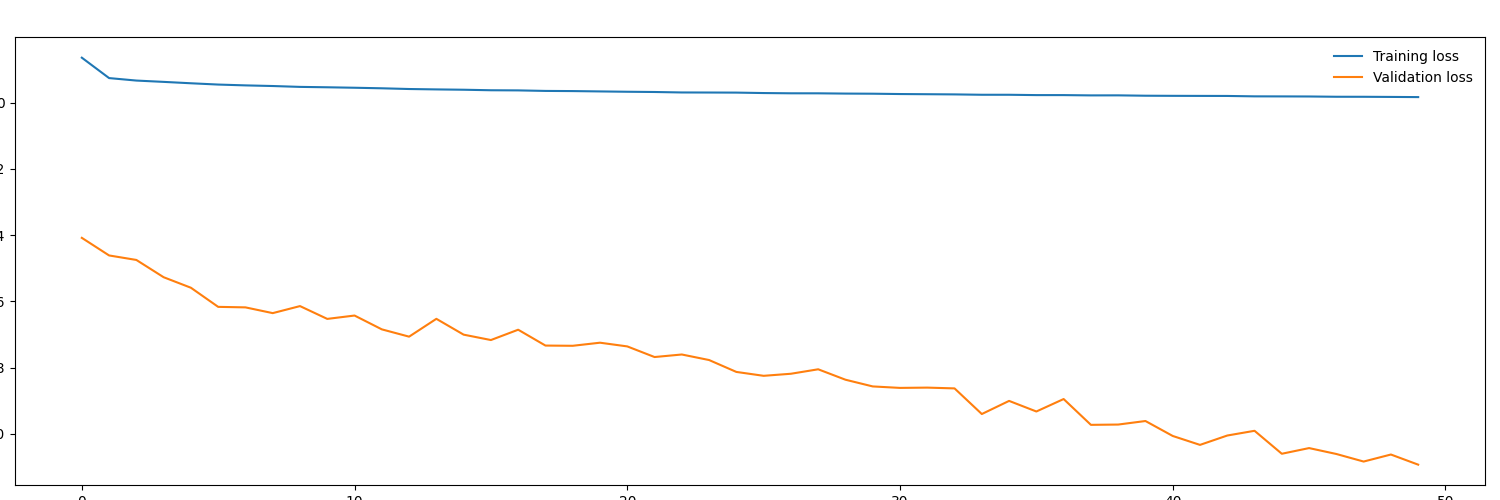

In [ ]:
plt.clf()
plt.plot(train_losses, label = "Training loss")
plt.plot(test_losses, label = "Validation loss")
plt.legend(frameon = False)
plt.show()


In [ ]:
from time import time
torch.save(model.state_dict(), f'{int(time())}_checkpoint.pth')

In [12]:
# model.load_state_dict()
model.load_state_dict(torch.load("1689517358_checkpoint.pth"))
model = model.eval()
def view_classify(img, ps, version="MNIST"):
    ''' Function for viewing an image and it's predicted classes.
    '''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    if version == "MNIST":
        ax2.set_yticklabels(np.arange(10))
    elif version == "Fashion":
        labels = ['T-shirt/top',
                            'Trouser',
                            'Pullover',
                            'Dress',
                            'Coat',
                            'Sandal',
                            'Shirt',
                            'Sneaker',
                            'Bag',
                            'Ankle Boot']
        ax2.set_yticklabels(labels, size='small');
        print("biggest val", labels[ps.tolist().index(max(ps))])
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()
    
dataiter = iter(test_load)
images, labels = next(dataiter)
img = images[0]


print(img[0][23])
# # Convert 2D image to 1D vector
# print(np.array(img).shape)
# # Calculate the class probabilites (log softmax) for img
# img = img.resize_(1, 1, 28, 28)
# ps = torch.exp(model(img))
# view_classify(img, ps, version='Fashion')

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -0.4510,  0.7490,  0.7412, -0.1137,
         0.0745,  0.8196,  0.6392,  0.6471,  0.6549,  0.6784,  0.6078,  0.6078,
         0.6549,  0.6000,  0.6157,  0.7412,  0.1529, -0.4902,  1.0000,  0.7176,
        -0.0824, -1.0000, -1.0000, -1.0000])
